<a href="https://colab.research.google.com/github/Rohit1217/VAE/blob/main/vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [80]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision import datasets,transforms
from torch.utils.data import TensorDataset,DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.nn.init as init

In [81]:
def get_device():
  return torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [82]:
# Transformations
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((128,),(128,))])

# Load MNIST dataset
trainset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
testset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Data loaders
trainloader = DataLoader(dataset=trainset, batch_size=128, shuffle=True)
testloader = DataLoader(dataset=testset, batch_size=128,shuffle=False)

In [83]:
class Encoder(nn.Module):
  def __init__(self,in_channels,out_channels,kernel,latent_dim):
    super(Encoder,self).__init__()
    self.in_channels=in_channels
    self.out_channels=out_channels
    self.latent_dim=latent_dim
    self.conv1=nn.Conv2d(in_channels,out_channels,kernel+2)
    self.conv2=nn.Conv2d(out_channels,out_channels,kernel)
    self.conv3=nn.Conv2d(out_channels,out_channels,kernel)
    self.conv4=nn.Conv2d(out_channels,out_channels,kernel)
    self.conv5=nn.Conv2d(out_channels,2,kernel)
    self.conv6=nn.Conv2d(out_channels,2,kernel)
    self.bn1=nn.BatchNorm2d(out_channels)
    self.bn2=nn.BatchNorm2d(out_channels)
    self.bn3=nn.BatchNorm2d(out_channels)
    self.bn4=nn.BatchNorm2d(out_channels)
    self.bn5=nn.BatchNorm2d(2)


  def forward(self,x):
    x=F.relu(self.bn1(self.conv1(x)))
    x=F.relu(self.bn2(self.conv2(x)))
    x=F.relu(self.bn3(self.conv3(x)))
    x=F.relu(self.bn4(self.conv4(x)))
    x=F.relu(self.bn5(self.conv5(x)))
    mean,log_variance=x[:,0],x[:,1]
    epsilon=torch.randn(self.latent_dim,self.latent_dim).to(get_device())
    z=mean+epsilon*(1+log_variance + torch.pow(log_variance,2))
    return mean,log_variance,z

'''enc=Encoder(1,64,5,6)
x=enc(torch.ones(6,1,28,28))
x[0].shape,x[2].shape'''

'enc=Encoder(1,64,5,6)\nx=enc(torch.ones(6,1,28,28))\nx[0].shape,x[2].shape'

In [84]:
class Decoder(nn.Module):
  def __init__(self,in_channels,out_channels,kernel,input_dim):
    super(Decoder,self).__init__()
    self.in_channels=in_channels
    self.out_channels=out_channels
    self.input_dim=input_dim
    self.conv1=nn.ConvTranspose2d(in_channels,out_channels,kernel )
    self.conv2=nn.ConvTranspose2d(out_channels,out_channels,kernel)
    self.conv3=nn.ConvTranspose2d(out_channels,out_channels,kernel)
    self.conv4=nn.ConvTranspose2d(out_channels,out_channels,kernel)
    self.conv5=nn.ConvTranspose2d(out_channels,1,kernel+2)
    self.conv6=nn.ConvTranspose2d(out_channels,out_channels,kernel)
    self.bn1=nn.BatchNorm2d(out_channels)
    self.bn2=nn.BatchNorm2d(out_channels)
    self.bn3=nn.BatchNorm2d(out_channels)
    self.bn4=nn.BatchNorm2d(out_channels)
    self.bn5=nn.BatchNorm2d(1)


  def forward(self,x):
    x=F.relu(self.bn1(self.conv1(x)))
    x=F.relu(self.bn2(self.conv2(x)))
    x=F.relu(self.bn3(self.conv3(x)))
    x=F.relu(self.bn4(self.conv4(x)))
    x=F.sigmoid(self.conv5(x))
    #mean,variance=x[:,0],x[:,1]
    #epsilon=torch.randn(self.input_dim,self.input_dim).to(get_device())
    #return mean+epsilon*variance
    return x + 1e-8

'''enc=Decoder(1,64,5,28)
x=enc(torch.ones(2,1,6,6))
x.shape,x'''

'enc=Decoder(1,64,5,28)\nx=enc(torch.ones(2,1,6,6))\nx.shape,x'

In [85]:
class encoder(nn.Module):
    def __init__(self):
      super(encoder,self).__init__()

      self.fc1=nn.Linear(784,500)
      self.fc2=nn.Linear(500,500)
      self.fc3=nn.Linear(500,128)

      init.xavier_uniform_(self.fc1.weight)
      init.xavier_uniform_(self.fc2.weight)
      init.xavier_uniform_(self.fc3.weight)

      self.bn1 = nn.BatchNorm1d(500)
      self.bn2 = nn.BatchNorm1d(500)
      self.bn3 = nn.BatchNorm1d(128)

    def forward(self,x):
      x=F.relu(self.bn1(self.fc1(x)))
      x=F.relu(self.bn2(self.fc2(x)))
      x=F.relu(self.bn3(self.fc3(x)))
      u,v=x[:,:64],x[:,64:]
      noise=torch.randn(64)
      noise=noise.to(get_device())
      x=u+torch.exp(0.5*v)*noise
      return u,v,x

class decoder(nn.Module):
  def __init__(self):
    super(decoder,self).__init__()

    self.fc4=nn.Linear(64,256)
    self.fc5=nn.Linear(256,400)
    self.fc6=nn.Linear(400,784)

    init.xavier_uniform_(self.fc4.weight)
    init.xavier_uniform_(self.fc5.weight)
    init.xavier_uniform_(self.fc6.weight)

    self.bn4 = nn.BatchNorm1d(256)
    self.bn5 = nn.BatchNorm1d(400)

  def forward(self,x):
      x = F.relu(self.bn4(self.fc4(x)))
      x = F.relu(self.bn5(self.fc5(x)))
      x = F.sigmoid(self.fc6(x))
      return x


In [118]:
class VAE(nn.Module):
  def __init__(self,input_dim,latent_dim,in_channels,out_channels,kernel):
    super(VAE,self).__init__()
    self.input_dim=input_dim
    self.latent_dim=latent_dim
    self.encoder2=Encoder(in_channels,out_channels,kernel,latent_dim)
    self.decoder2=Decoder(in_channels,out_channels,kernel,input_dim)
    self.e=1e-8
    self.encoder1=encoder()
    self.decoder1=decoder()
    self.e=1e-8

  def forward(self,x):
    mean,log_variance,z=self.encoder2(x)
    b,w,h=z.shape
    z=z.view(b,1,w,h)
    x=x.view(b,self.input_dim,self.input_dim)
    x_re=self.decoder2(z)
    return x_re,x,mean,log_variance

'''vae=VAE(28,6,1,64,5)
x=vae(torch.rand(6,1,28,28))
x[0].shape,x[1].shape,x[2].shape,x[3].shape,x'''

'vae=VAE(28,6,1,64,5)\nx=vae(torch.rand(6,1,28,28))\nx[0].shape,x[1].shape,x[2].shape,x[3].shape,x'

In [87]:
class VAE1(nn.Module):
  def __init__(self,input_dim,latent_dim,in_channels,out_channels,kernel):
    super(VAE1,self).__init__()
    self.input_dim=input_dim
    self.latent_dim=latent_dim
    self.encoder2=Encoder(in_channels,out_channels,kernel,latent_dim)
    self.decoder2=Decoder(in_channels,out_channels,kernel,input_dim)
    self.e=1e-8
    self.encoder1=encoder()
    self.decoder1=decoder()
    self.e=1e-8

  def forward(self,x):
    mean,log_variance,z=self.encoder1(x)
    x_re=self.decoder1(z)
    return x_re,x,mean,log_variance

In [106]:
def Loss1(x_re,x_or,mean,log_variance):
  re_loss=F.binary_cross_entropy(x_re,x_or,reduction='sum')
  kl=torch.sum(-0.5*(1+log_variance-torch.exp(log_variance)-torch.pow(mean,2)))
  return (re_loss+kl)

In [100]:
def Loss(x_re,x_or,mean,log_variance):
  b,c,c=mean.shape
  x_re=x_re.view(b,28,28)
  re_loss=F.binary_cross_entropy(x_re,x_or,reduction='sum')
  log_variance=log_variance.view(b,c*c)
  mean=mean.view(b,c*c)
  kl=torch.sum(-0.5*(1+log_variance-torch.exp(log_variance)-torch.pow(mean,2)))
  #kl=torch.mean(kl)
  #print(f're{re_loss},kl{kl}')
  return (re_loss+kl)

'Loss(x[0],x[1],x[2],x[3])'

In [119]:
model=VAE(28,6,1,64,5)
model=model.to(get_device())
epochs=50
optimizer=optim.Adam(model.parameters(),lr=0.001)

In [120]:
for epoch in range(epochs):
  total_loss=0
  count=0
  for x,_ in trainloader:
    model.train()
    x=x*0.5+0.5
    b,t,c,c=x.shape
    x=x.view(b,c*c)
    x=x.to(get_device())
    x_re,x,mean,log_variance=model(x)
    print(x_re)
    loss=Loss1(x_re,x,mean,log_variance)

    total_loss+=loss.item()
    count+=1
    #print(total_loss)

    optimizer.zero_grad()
    loss.backward()
    #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()

    #for name, param in model.decoder.named_parameters():
    #  if param.grad is not None:
    #    pass
    #      #print(f'a')
      #print(x_re,x,mean,log_variance,loss)


  print(f'total_loss{total_loss},mse_loss{total_loss/count},epoch{epoch}')

RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [128, 784]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

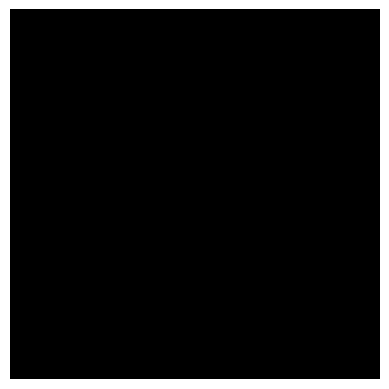

In [114]:
with torch.no_grad():
  model.eval()
  for x,_ in trainloader:
    #print(x)
    #x=torch.randn(128,784)
    #print(x.shape)
    x=0.5*x+0.5
    b,t,c,c=x.shape
    x=x.view(b,c*c)
    x=x.to('cuda:0')
    #u,v,z=model.encoder1(x)
    #print(z.shape,z[0])
    #z=z.to('cuda:0')
    #x=model.decoder1(z)
    x,x_or,mean,log_variance=model(x)

    print(x[0])
    x=x[0]
    x=x.view(28,28)
    #x=data[0].view(28,28)
    x=x.to('cpu')
    image_np = x.detach().numpy()

    # Display the image using matplotlib
    plt.imshow(image_np, cmap='gray')  # 'gray' colormap is used for grayscale images
    plt.axis('off')  # Turn off axis labels
    plt.show()
    break

In [ ]:
with torch.no_grad():
  model.eval()
  for x,_ in trainloader:
    y=x
    x=x.to(get_device())
    x=x*0.5+0.5
    z=torch.randn(6,1,6,6)
    z=z.to('cuda:0')
    mean,log_variance,z=model.encoder2(x)
    z=z.view(128,1,6,6)
    x=model.decoder2(z)
    print(x[0].shape)
    x=x[10]
    #x=torch.bernoulli(x.float())
    x=x.view(28,28)
    #x=data[0].view(28,28)
    x=x.to('cpu')
    image_np = x.detach().numpy()
    break
  # Display the image using matplotlib

  plt.imshow(image_np, cmap='gray')  # 'gray' colormap is used for grayscale images
  plt.axis('off')  # Turn off axis labels
  plt.show()